In [ ]:
import os
import glob
#from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import xml.etree.ElementTree as ET
import tensorflow as tf
from keras.models import load_model
import cv2

In [ ]:
! apt install tesseract-ocr
! apt install libtesseract-dev

In [ ]:
! pip install Pillow
! pip install pytesseract

In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
import pytesseract
from PIL import ImageEnhance, ImageFilter, Image

In [ ]:
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

In [ ]:
!wget --header="Host: doc-0o-3o-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_sdg3i7v4ri7e38pdfprsctq13ekkc1am_nonce=3h89v086h91oq" --header="Connection: keep-alive" "https://doc-0o-3o-docs.googleusercontent.com/docs/securesc/c7h9tlgpbqilf9nmomrdtg90qdn0nlc3/mghjafha8me0srhbrb62kpc0c7ea6lam/1624794825000/00048055783660299439/13937806133259344158/1Ms3h7oNoWZxR0nnW_1D_Vq9F254wqSXp?e=download&authuser=0&nonce=3h89v086h91oq&user=13937806133259344158&hash=e9nhlj0bb0a4g204488rb7fdokjr00dq" -c -O 'Marmot_data.zip'

--2021-06-27 11:54:58--  https://doc-0o-3o-docs.googleusercontent.com/docs/securesc/c7h9tlgpbqilf9nmomrdtg90qdn0nlc3/mghjafha8me0srhbrb62kpc0c7ea6lam/1624794825000/00048055783660299439/13937806133259344158/1Ms3h7oNoWZxR0nnW_1D_Vq9F254wqSXp?e=download&authuser=0&nonce=3h89v086h91oq&user=13937806133259344158&hash=e9nhlj0bb0a4g204488rb7fdokjr00dq
Resolving doc-0o-3o-docs.googleusercontent.com (doc-0o-3o-docs.googleusercontent.com)... 142.250.141.132, 2607:f8b0:4023:c0b::84
Connecting to doc-0o-3o-docs.googleusercontent.com (doc-0o-3o-docs.googleusercontent.com)|142.250.141.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘Marmot_data.zip’

Marmot_data.zip         [       <=>          ]  65.63M  42.1MB/s    in 1.6s    

2021-06-27 11:55:00 (42.1 MB/s) - ‘Marmot_data.zip’ saved [68820548]



In [ ]:
!unzip Marmot_data.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Dropout, Dense, Flatten, Input, Concatenate, UpSampling2D, Conv2DTranspose

In [ ]:
def table_decoder(x, vgg19_pool3, vgg19_pool4):
  x = Conv2D(512, (1,1), activation = 'relu', name = 'conv7_table')(x)
  x = UpSampling2D((2,2), name = '2xconv7_table')(x)
  x = Concatenate()([x,vgg19_pool4])
  x = UpSampling2D((2,2), name = '2x_pool4_2xconv7_table')(x)
  x = Concatenate()([x, vgg19_pool3])
  x = UpSampling2D(size=(2,2))(x)
  x = UpSampling2D(size=(2,2))(x)
  x =  Conv2DTranspose(3,3, strides= 2 , padding = 'same', name = 'table_mask')(x)
  return x

In [ ]:
def column_decoder(x, vgg19_pool3, vgg19_pool4):
  x = Conv2D(512, (1,1), activation='relu', name = 'conv7_column')(x)
  x = Dropout(0.8)(x)
  x = Conv2D(512, (1,1), activation='relu', name = 'conv8_column')(x)
  x = UpSampling2D((2,2), name = '2xconv8_column')(x)
  x = Concatenate()([x, vgg19_pool4])
  x = UpSampling2D((2,2), name = '2x_pool4_2xconv8_column')(x)
  x = Concatenate()([x, vgg19_pool3])
  x = UpSampling2D(size=(2,2))(x)
  x = UpSampling2D(size=(2,2))(x)
  x =  Conv2DTranspose(3,3, strides=2, padding = 'same', name = 'column_mask')(x)
  return x

In [ ]:
tf.keras.backend.clear_session()
input = Input((256,256,3), name = 'input')
vgg_19 = tf.keras.applications.VGG19(include_top=False, weights = 'imagenet', input_tensor=input)
print(f'VGG19 ouput shape :{vgg_19.output_shape}')
vgg19_pool3 = vgg_19.get_layer('block3_pool').output
print(f'VGG19 pool3 layer output shape : {vgg19_pool3.shape}')
vgg19_pool4 = vgg_19.get_layer('block4_pool').output
print(f'VGG19 pool4 layer output shape : {vgg19_pool4.shape}')

x = Conv2D(512, (1,1), activation='relu', name = 'block6_conv1')(vgg_19.output)
x = Dropout(0.8)(x)
x = Conv2D(512, (1,1), activation='relu', name = 'block6_conv2')(x)
x = Dropout(0.8)(x)
print(f'Shape of encoder output: {x.shape}')

80142336/80134624 [==============================] - 1s 0us/step
VGG19 ouput shape :(None, 8, 8, 512)
VGG19 pool3 layer output shape : (None, 32, 32, 256)
VGG19 pool4 layer output shape : (None, 16, 16, 512)
Shape of encoder output: (None, 8, 8, 512)


In [ ]:
table_mask = table_decoder(x, vgg19_pool3, vgg19_pool4)
column_mask = column_decoder(x, vgg19_pool3, vgg19_pool4)

In [ ]:
model =  Model(inputs = input, outputs = [table_mask, column_mask], name = 'tablenet')

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/tablenet_new/model_148')

In [ ]:
def predict(filepath):
  img = cv2.imread(filepath)
  img = cv2.resize(img,(1024,1024), cv2.INTER_AREA)
  img_256 = cv2.resize(img,(256,256), cv2.INTER_NEAREST)
  if img_256.shape[2] == 4:
    img_256 = cv2.cvtColor(img_256, cv2.COLOR_RGBA2RGB)
  elif img_256.shape[2] == 1:
    img_256 = cv2.cvtColor(img_256, cv2.COLOR_GRAY2RGB)
  else:
    img_256 = cv2.cvtColor(img_256, cv2.COLOR_BGR2RGB)
  img_256 = np.expand_dims(img_256, axis = 0)
  print('Predicting....')
  pred_mask1, pred_mask2 = model.predict(img_256)

  pred_tabmask = tf.argmax(pred_mask1, axis=-1)
  pred_tabmask = pred_tabmask[..., tf.newaxis]
  pred_colmask = tf.argmax(pred_mask2, axis=-1)
  pred_colmask = pred_colmask[..., tf.newaxis]
  pred_table_mask = pred_tabmask[0]
  pred_column_mask = pred_colmask[0]

  pred_table_mask = tf.keras.preprocessing.image.array_to_img(pred_table_mask)
  pred_column_mask = tf.keras.preprocessing.image.array_to_img(pred_column_mask)
  pred_table_mask = cv2.resize(np.array(pred_table_mask), (1024,1024), cv2.INTER_NEAREST)
  pred_column_mask = cv2.resize(np.array(pred_column_mask), (1024,1024), cv2.INTER_NEAREST)
  pred_table_mask = tf.keras.preprocessing.image.array_to_img(pred_table_mask[:,:,np.newaxis])
  pred_column_mask = tf.keras.preprocessing.image.array_to_img(pred_column_mask[:,:,np.newaxis])

  img_final = tf.keras.preprocessing.image.array_to_img(img)
  img_final.putalpha(pred_table_mask)
  print('Extracting text...')
  text = pytesseract.image_to_string(img_final)
  plt.figure(figsize = (10,10))
  #plt.imshow(img)
  plt.imshow(img_final)
  plt.title('Detected Table')
  plt.show()
  if len(text) ==1:
    print('No table is present in the image')
  else:
    print('The detected text is:')
    print('\n')
    print(text)

Predicting....
Extracting text...


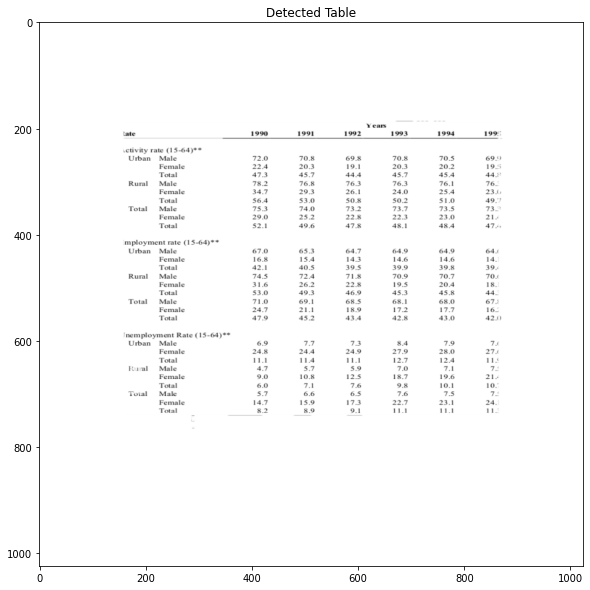

The detected text is:


Years

 

tate 1990 1991 1992 1993 1994 199°
setivity rate (15-64)"*
Urban Male 720 70.8 69.8 70.8 70.5 69.9
Female 224 20.3 19.1 20.3 20.2 19.5
Total 473 437 444 457 45.4 44.
Rural Male 78.2 76.8 763 763 76.1 76.
Female 34.7 29.3 26.1 24.0 25.4 234
Total 56.4 53.0 50.8 50.2 51.0 49.7
Total Male 753 74.0 73.2 73.7 735 73.
Female 29.0 25.2 22.8 22.3 23.0 21.
Total S24 49.6 478 48.1 4R4 aT
mployment rate (15-64)**
Urban Male 67.0 653 64.7 649 649 64.
Female 16.8 15.4 143 14.6 14.6 14
Total 424 40.5 39.5 39.9 39.8 39.
Rural Male 74.5 72.4 718 709 70.7 70.
Female 316 26.2 22.8 19.5 20.4 18.
Total 33.0 493 46.9 433 45.8 44
Total Male 710 69.4 68s 68.1 68.0 67.
Female 24.7 244 18.9 172 177 16.
Total 479 452 434 42.8 43.0 420
employment Rate (15-64)**
Urban Male 69 77 73 84 Te
Female 24.8 244 249 279 274
Total Ma 14 Ma 12.7 1s
Toral Male a7 37 39 70 7
Female 90 10.8 12.5 18.7 21
Total 6.0 7 76 Os 10
Toial Male 37 66 6S 76 7
Female 147 15.9 173 22.7 24.
Total 82 89 on m

In [ ]:
predict('/content/10.1.1.1.2013_63.bmp')

Predicting....
Extracting text...


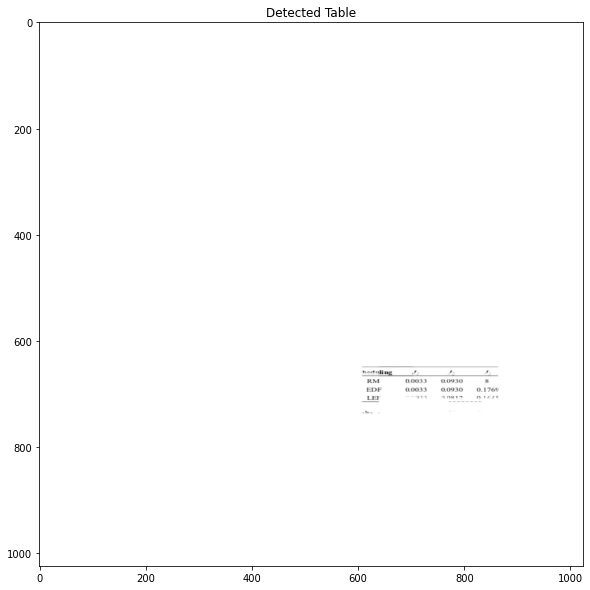

The detected text is:


pectin
0.0033 0.0930 =
0.0033 0.0930 0.1768

 

    



In [ ]:
predict('/content/10.1.1.1.2006_3.bmp')

Converting to Tflite

In [ ]:
def get_filesize(filepath):
  size = 0
  for f in os.listdir(filepath):
    if 'model' in f:
      size += os.path.getsize(os.path.join(filepath,f))
    elif 'variables' in f:
      new_path = os.path.join(filepath,f)
      for _ in os.listdir(new_path):
        size += os.path.getsize(os.path.join(new_path,_))
  print('File Size : ' + str(round(size /(1024 *1024),3)) + ' MB')

In [ ]:
get_filesize('/content/drive/MyDrive/Colab Notebooks/tablenet_new/model_148')

File Size : 245.805 MB


In [ ]:
def getsize_tflite(filepath):
  size = os.path.getsize(filepath)
  print('File Size : ' + str(round(size /(1024 *1024),3)) + ' MB')

The original model is of size 245 MB

In [ ]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp9gtqh36c/assets


In [ ]:
open('tflite_model.tflite', 'wb').write(tflite_model)

21613552

In [ ]:
getsize_tflite('tflite_model.tflite')

File Size : 20.612 MB


The size of the model is now reduced from 245 MB to 20.612 MB

In [ ]:
import os.path
from os import path

In [ ]:
from google.colab import files
files.download('tflite_model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
tflite_interpreter = tf.lite.Interpreter(model_path='tflite_model.tflite')

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

In [ ]:
print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

== Input details ==
name: input
shape: [  1 256 256   3]
type: <class 'numpy.float32'>


In [ ]:
print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])


== Output details ==
name: Identity
shape: [  1 256 256   3]
type: <class 'numpy.float32'>


In [ ]:
print("\n== Output details ==")
print("name:", output_details[1]['name'])
print("shape:", output_details[1]['shape'])
print("type:", output_details[1]['dtype'])


== Output details ==
name: Identity_1
shape: [  1 256 256   3]
type: <class 'numpy.float32'>


In [ ]:
def predict_lite(filepath):
  img = cv2.imread(filepath)
  img = cv2.resize(img,(1024,1024), cv2.INTER_AREA)
  img_256 = cv2.resize(img,(256,256), cv2.INTER_NEAREST)
  if img_256.shape[2] == 4:
    img_256 = cv2.cvtColor(img_256, cv2.COLOR_RGBA2RGB)
  elif img_256.shape[2] == 1:
    img_256 = cv2.cvtColor(img_256, cv2.COLOR_GRAY2RGB)
  else:
    img_256 = cv2.cvtColor(img_256, cv2.COLOR_BGR2RGB)
  img_256 = np.expand_dims(img_256, axis = 0)
  img_256 = img_256.astype(np.float32)

  print('Predicting....')
  tflite_interpreter = tf.lite.Interpreter(model_path='tflite_model.tflite')
  input_details = tflite_interpreter.get_input_details()
  output_details = tflite_interpreter.get_output_details()
  tflite_interpreter.allocate_tensors()
  tflite_interpreter.set_tensor(input_details[0]['index'], img_256)
  tflite_interpreter.invoke()

  pred_mask1 = tflite_interpreter.get_tensor(output_details[0]['index'])
  pred_mask2 = tflite_interpreter.get_tensor(output_details[1]['index'])
  pred_tabmask = tf.argmax(pred_mask1, axis=-1)
  pred_tabmask = pred_tabmask[..., tf.newaxis]
  pred_colmask = tf.argmax(pred_mask2, axis=-1)
  pred_colmask = pred_colmask[..., tf.newaxis]
  pred_table_mask = pred_tabmask[0]
  pred_column_mask = pred_colmask[0]
  pred_table_mask = tf.keras.preprocessing.image.array_to_img(pred_table_mask)
  pred_column_mask = tf.keras.preprocessing.image.array_to_img(pred_column_mask)
  pred_table_mask = cv2.resize(np.array(pred_table_mask), (1024,1024), cv2.INTER_NEAREST)
  pred_column_mask = cv2.resize(np.array(pred_column_mask), (1024,1024), cv2.INTER_NEAREST)
  pred_table_mask = tf.keras.preprocessing.image.array_to_img(pred_table_mask[:,:,np.newaxis])
  pred_column_mask = tf.keras.preprocessing.image.array_to_img(pred_column_mask[:,:,np.newaxis])
  
  img_final = tf.keras.preprocessing.image.array_to_img(img)
  img_final.putalpha(pred_table_mask)
  print('Extracting text...')
  text = pytesseract.image_to_string(img_final)
  plt.figure(figsize = (10,10))
  #plt.imshow(img)
  plt.imshow(img_final)
  plt.title('Detected Table')
  plt.show()
  if len(text) ==1:
    print('No table is present in the image')
  else:
    print('The detected text is:')
    print('\n')
    print(text)

Predicting....
Extracting text...


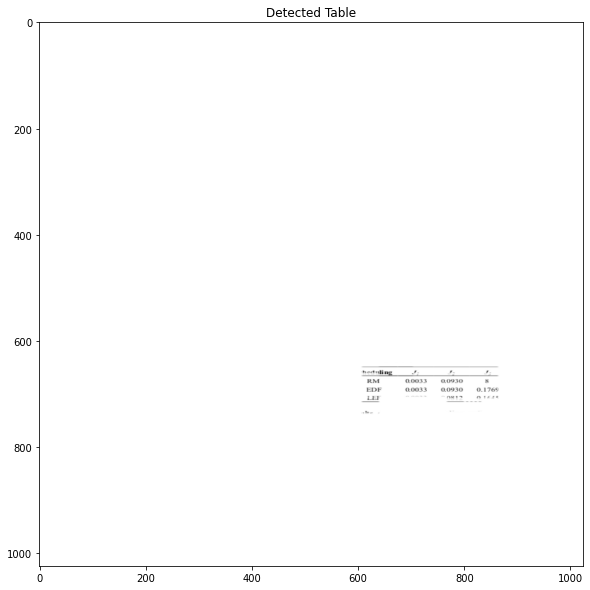

The detected text is:


petri
0.0033 00930
0.0033 0.0930 0.1768

 

 

 



In [ ]:
predict_lite('/content/10.1.1.1.2006_3.bmp')